In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
import time
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import ngrams
from collections import Counter

In [2]:
train_data = pd.read_csv('../../dataset2/dataset/train_data.csv')  
val_data = pd.read_csv('../../dataset2/dataset/val_data.csv')   
test_data = pd.read_csv('../../dataset2/dataset/test_data.csv') 

In [3]:
x_train, y_train = train_data['text'], train_data['label']
x_val, y_val = val_data['text'], val_data['label']
x_test, y_test = test_data['text'], test_data['label']

In [4]:
x_train_tokens = x_train.apply(lambda x: x.lower().split())
x_val_tokens = x_val.apply(lambda x: x.lower().split())
x_test_tokens = x_test.apply(lambda x: x.lower().split())

In [5]:
t_start = time.time()
word2vec_model = Word2Vec(sentences=x_train_tokens, vector_size=100, window=5, min_count=1, workers=4, sg=0, seed=42)
t_end = time.time()
print('Time taken to build Word2Vec model: {} seconds'.format(t_end - t_start))

pickle.dump(word2vec_model, open('./models/word2vecCB.pkl',"wb"))

Time taken to build Word2Vec model: 136.32139205932617 seconds


In [6]:
# word2vec_model = np.load('./models/word2vecCB.pkl',allow_pickle=True)

In [7]:
def text_to_vector(words, model):
    valid_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(valid_vectors, axis=0) if valid_vectors else np.zeros(model.vector_size)

In [8]:
train_embeddings = np.array([text_to_vector(sentence, word2vec_model) for sentence in x_train_tokens])
val_embeddings = np.array([text_to_vector(sentence, word2vec_model) for sentence in x_val_tokens])
test_embeddings = np.array([text_to_vector(sentence, word2vec_model) for sentence in x_test_tokens])

In [9]:
t_start = time.time()
random_forest = RandomForestClassifier(
    n_estimators=200,       
    max_depth=10,           
    min_samples_split=5,     
    min_samples_leaf=2,      
    max_features="sqrt",     
    class_weight="balanced", 
    bootstrap=True,         
    random_state=42,
    verbose=1
)
random_forest.fit(train_embeddings, y_train)
t_end = time.time()
print('Time taken to fit Random Forest model: {}'.format(t_end - t_start))
pickle.dump(word2vec_model, open('./models/random_forest_word2vecCB.pkl',"wb"))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   21.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.4min


Time taken to fit Random Forest model: 82.97754716873169


In [10]:
# random_forest = np.load('./models/random_forest_word2vecCB.pkl',allow_pickle=True)

In [11]:
y_pred = random_forest.predict(val_embeddings)
accuracy = accuracy_score(y_pred, y_val)
print(f"Validation accuracy: {accuracy}")

Validation accuracy: 0.9072385294955828


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


In [12]:
y_pred = random_forest.predict(test_embeddings)
accuracy = accuracy_score(y_pred, y_test)
print(f"Test accuracy: {accuracy}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Test accuracy: 0.914505557138786


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [13]:
y_test

0       0
1       1
2       0
3       0
4       0
       ..
7013    1
7014    0
7015    1
7016    1
7017    1
Name: label, Length: 7018, dtype: int64

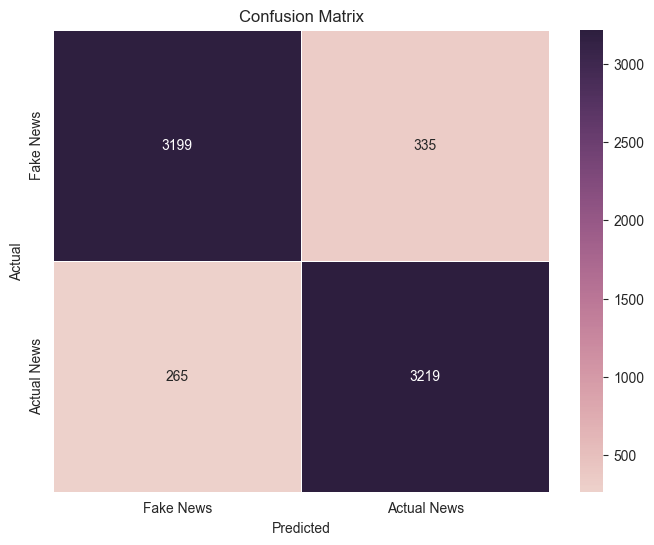

In [14]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.set_style("dark")
sns.heatmap(cm, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=['Fake News', 'Actual News'], yticklabels=['Fake News', 'Actual News'],linewidth=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('./plots/confusion_matrixCB.png')
plt.show()


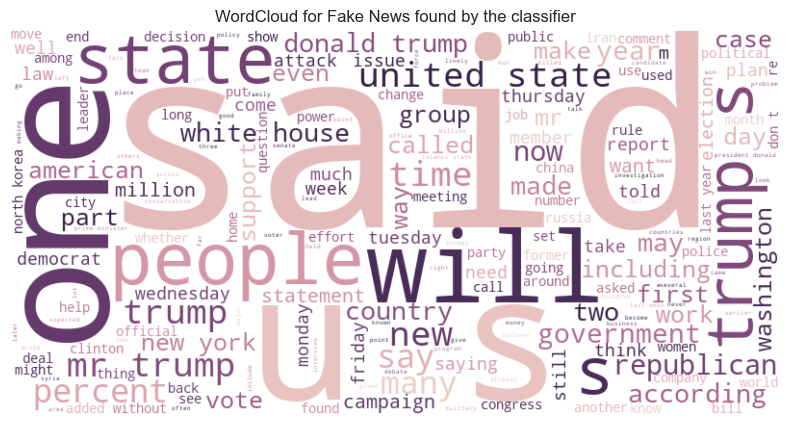

In [15]:
fake_news_text_data = ' '.join([' '.join(sentence) for sentence, label in zip(x_test_tokens, y_pred) if label == 0])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap= sns.cubehelix_palette(as_cmap=True)).generate(fake_news_text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Fake News found by the classifier')
plt.savefig('./plots/wordcloudCB.png')
plt.show()


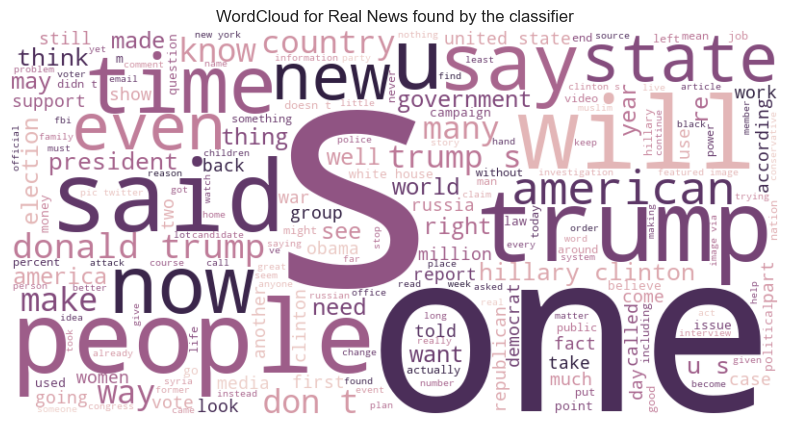

In [23]:
fake_news_text_data = ' '.join([' '.join(sentence) for sentence, label in zip(x_test_tokens, y_pred) if label == 1])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap= sns.cubehelix_palette(as_cmap=True)).generate(fake_news_text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Real News found by the classifier')
plt.savefig('./plots/wordcloudCB_real.png')
plt.show()


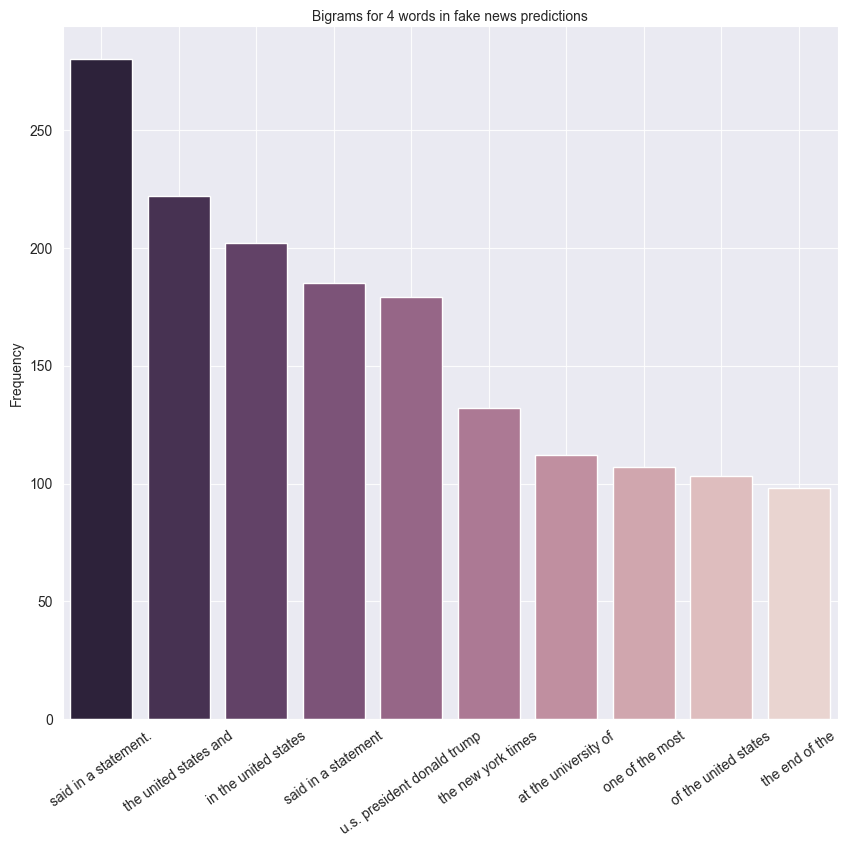

In [24]:
fake_news_sentences = [sentence for sentence, label in zip(x_test_tokens, y_pred) if label == 0]

bigrams = [ngram for sentence in fake_news_sentences for ngram in ngrams(sentence, 4)]
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
bigrams, counts = zip(*most_common_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigrams]
plt.figure(figsize=(10, 9))
reversed_palette = sns.cubehelix_palette( n_colors=10,reverse=True)

sns.barplot(x=bigram_labels, y=counts, palette=reversed_palette, hue=bigram_labels, legend=False)
plt.xticks(rotation=35)
plt.xlabel('Bigrams for 4 words in fake news predictions')
plt.gca().xaxis.set_label_position('top')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.9)
plt.grid(axis='x', alpha=0.9)
plt.savefig("./plots/biogram4CB_fake.png")
plt.show()


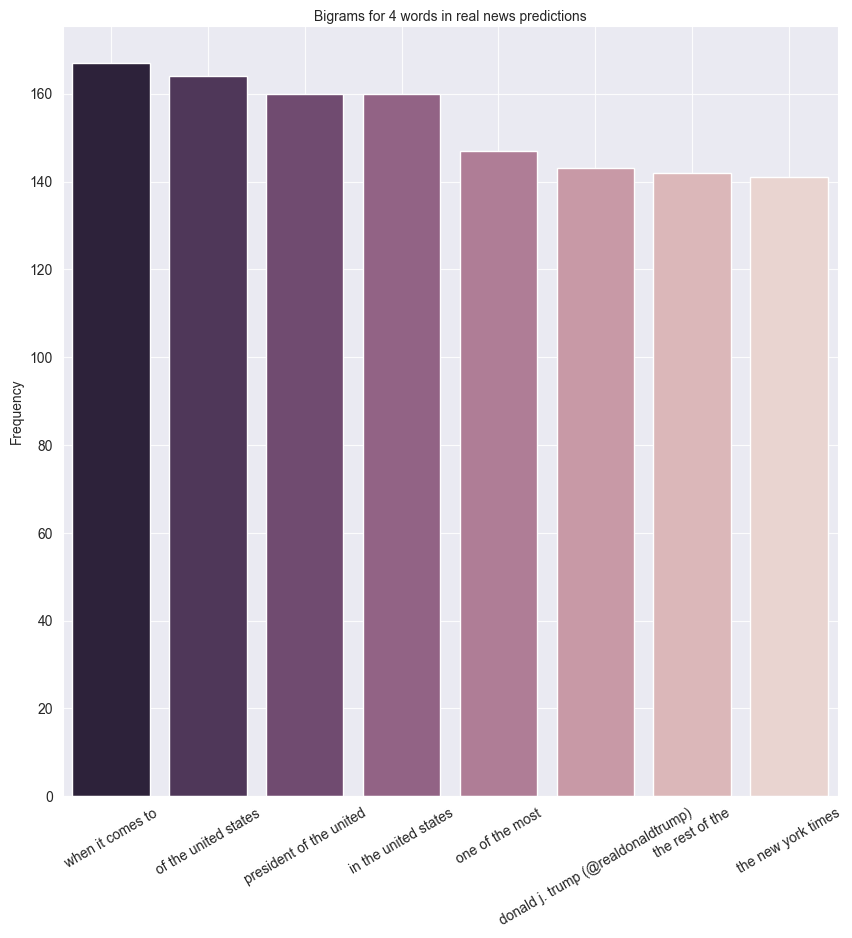

In [28]:
fake_news_sentences = [sentence for sentence, label in zip(x_test_tokens, y_pred) if label == 1]

bigrams = [ngram for sentence in fake_news_sentences for ngram in ngrams(sentence, 4)]
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(8)
bigrams, counts = zip(*most_common_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigrams]
plt.figure(figsize=(10, 10))
reversed_palette = sns.cubehelix_palette( n_colors=8,reverse=True)

sns.barplot(x=bigram_labels, y=counts, palette=reversed_palette, hue=bigram_labels, legend=False)
plt.xticks(rotation=30)
plt.xlabel('Bigrams for 4 words in real news predictions')
plt.gca().xaxis.set_label_position('top')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.9)
plt.grid(axis='x', alpha=0.9)
plt.savefig("./plots/biogram4CB_real.png")
plt.show()


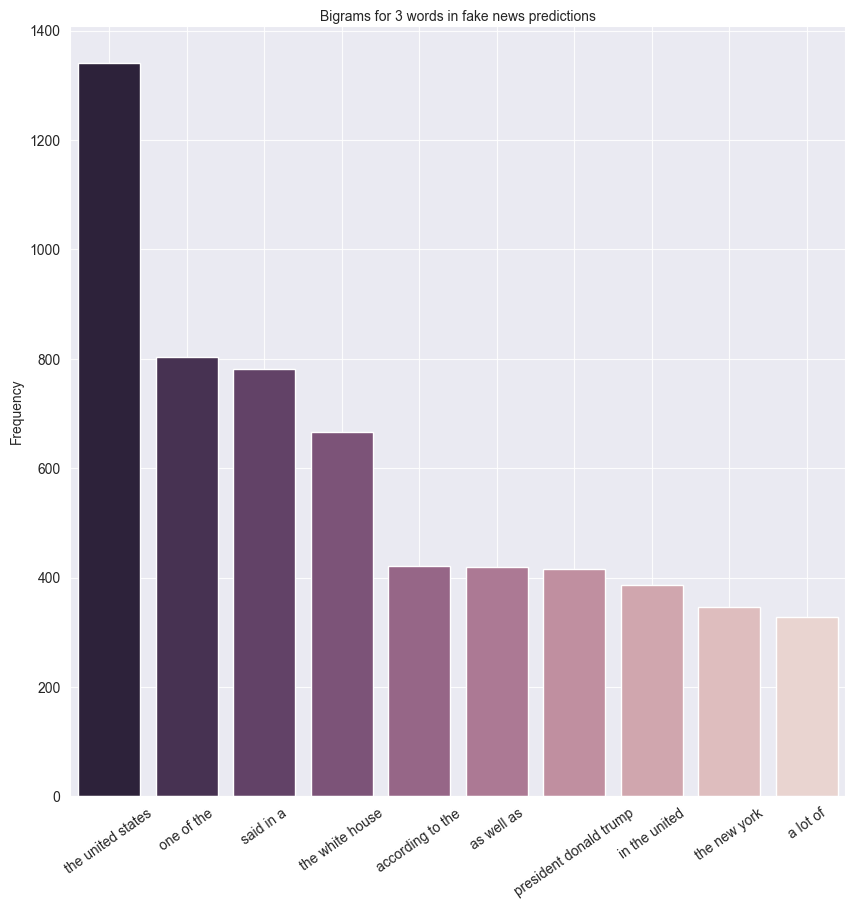

In [22]:
fake_news_sentences = [sentence for sentence, label in zip(x_test_tokens, y_pred) if label == 0]

bigrams = [ngram for sentence in fake_news_sentences for ngram in ngrams(sentence, 3)]
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
bigrams, counts = zip(*most_common_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigrams]
plt.figure(figsize=(10, 10))
reversed_palette = sns.cubehelix_palette( n_colors=10,reverse=True)

sns.barplot(x=bigram_labels, y=counts, palette=reversed_palette, hue=bigram_labels, legend=False)
plt.xticks(rotation=35)
plt.xlabel('Bigrams for 3 words in fake news predictions')
plt.gca().xaxis.set_label_position('top')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.9)
plt.grid(axis='x', alpha=0.9)
plt.savefig("./plots/biogram3CB_fake.png")
plt.show()
